In [115]:
from montu import *
import matplotlib.pyplot as plt
from astropy.time import Time
from astroquery.jplhorizons import Horizons

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare environment

We need to get and connect the files for ephemerides calculation:

In [116]:
# Load SPICE data
Montu.load_kernels()

Loading kernel de441_part-1.bsp
Loading kernel de441_part-2.bsp
Loading local kernel frame.tk
Loading local kernel pck00011.tpc
Loading local kernel earth_assoc_itrf93.tf


## The stars

The package is provided with a catalogue with all stars between magnitude -1.44 and magnitude 21.

In [3]:
allstars=Stars()

Get Aldebaran position and stars around it:

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: xlabel='RA [deg]', ylabel='Dec [deg]'>)

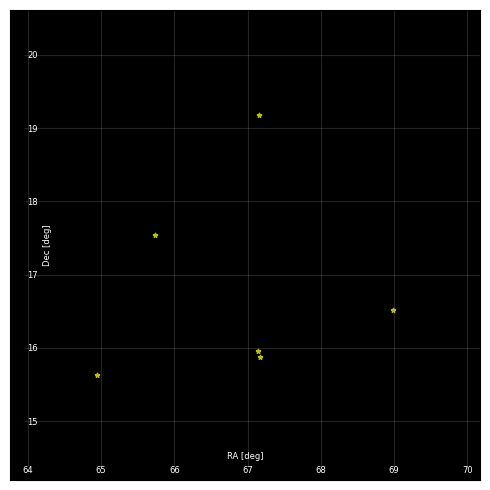

In [4]:
aldebaran = allstars.get_stars(ProperName='Aldebaran')
hyades = allstars.get_stars_area(RA=aldebaran.data.RA,Dec=aldebaran.data.Dec,radius=5,Mag=[-1,4])
hyades.plot_stars(pad=0.1)

## Time issues

`SPICE` works with the Gregorian calendar, so, it is hard to compare dates between 59 b.c. and 1582 a.d.  For instance:

In [5]:
date = '1000 B.C. 09-07 12:00:00'
et = spy.utc2et(date)
dt = spy.deltet(et,"ET")
et -= dt
print(dt)
jd = spy.unitim(et,"ET","JDTDB") 
jd

41.18247463623287


1356432.0

This julian day, however, correspond to september the 16th in the Julian Calendar which is the date assumed in NASA `Horizons` system. If you compute the coordinates of Mars at that date with `SPICE`` you obtain:

In [6]:
X,lt = spy.spkezr('4',et,'J2000','LT+S','399')
r,RA,DEC = spy.reclat(X[:3])
ra = np.mod(RA*RAD,360)/15
jd, Montu.dec2hex(ra), Montu.dec2hex(DEC*RAD)

(1356432.0, (18.0, 30, 29.027181943781954), (-25.0, 31, 5.584286831078487))

Using `astroquery`:

In [7]:
RA,DEC = list(Horizons(id='4',location='399',epochs=jd).ephemerides().to_pandas().loc[0,['RA','DEC']])
Montu.dec2hex(RA/15), Montu.dec2hex(DEC)

((18.0, 31, 25.497600000005036), (-25.0, 30, 27.28800000000291))

Using `Horizons` app you get: RA = 18 30 29.53, DEC = -25 31 04.6. However in `Horizons` the mixed calendar date is September the 16th, 1000 b.c.

In `Stellarium` the same date give us this position for Mars: RA = 18 31 22.81, Dec = -25 30 22.1. Additionally `Stellarium` use a date with negative numbers, so the date corresponding to JD = 1356432 is -999 september the 16th, 12:03:44.

**Conclusions**:
- The results with SPICE nicely agree with HORIZONS provided the date given to Horizons is the JDTDB, not the UTC date.
- The results of astroquery are not as accurate as SPICE.
- The results with Stellarium are off by around 1 arcmin which for the purposes of Cultural Astronomy are not important.

Let's see what happen in `astropy`:

In [8]:
time = Time(jd,format='jd',scale='tt').iso
time

'-999-09-07 12:00:00.000'

A last option is to work with `numpy.datetime64` (see https://numpy.org/doc/stable/reference/arrays.datetime.html):

In [9]:
# date = '1000 B.C. 09-07 12:00:00'
date = '-999-09-07 12:00:00.00'
time = np.datetime64(date)
time

numpy.datetime64('-999-09-07T12:00:00.000')

You may generate arrays of times:

In [10]:
np.arange('-999-02', '-999-03', dtype='datetime64[D]')

array(['-999-02-01', '-999-02-02', '-999-02-03', '-999-02-04',
       '-999-02-05', '-999-02-06', '-999-02-07', '-999-02-08',
       '-999-02-09', '-999-02-10', '-999-02-11', '-999-02-12',
       '-999-02-13', '-999-02-14', '-999-02-15', '-999-02-16',
       '-999-02-17', '-999-02-18', '-999-02-19', '-999-02-20',
       '-999-02-21', '-999-02-22', '-999-02-23', '-999-02-24',
       '-999-02-25', '-999-02-26', '-999-02-27', '-999-02-28'],
      dtype='datetime64[D]')

Or perform operations:

In [11]:
np.datetime64('-999-09-07 12:00:00.00') + np.timedelta64(1,'D')

numpy.datetime64('-999-09-08T12:00:00.000')

**Conclusions**:
- The results with SPICE nicely agree with HORIZONS provided the date given to Horizons is the JDTDB, not the UTC date.
- The results of astroquery are not as accurate as SPICE.
- The results with Stellarium are off by around 1 arcmin which for the purposes of Cultural Astronomy are not important.

### The class `MonTime`

For managing times we have designed a special class `MonTime`. If you provide to the class a simple string in different formats you can obtain many different properties of the time. For instance:

In [12]:
mtime_ini = MonTime('-1470-01-01 12:00:00.00')
print(mtime_ini.__dict__)

{'datestr': '-1470-01-01 12:00:00.00', 'bce': True, 'datetime64': numpy.datetime64('-1470-01-01T12:00:00.000'), 'cal': array([-1.47e+03,  1.00e+00,  1.00e+00,  1.20e+01,  0.00e+00,  0.00e+00,
        0.00e+00]), 'datespice': '1471 B.C. 01-01 12:00:00.0', 'et': -109502582399.99998, 'deltat': 41.185396343449355, 'jd': 1184154.0000000002, 'astrotime': <Time object: scale='tdb' format='jd' value=1184154.0000000002>}


## Planetary ephemerides

In [13]:
p = Planet(id='4')
mtime = MonTime('-999-09-07 12:00:00.00')
print(mtime.jd)
p.calc_ephemerides(mtime.et)

Montu.dec2hex(p.RAJ2000), Montu.dec2hex(p.DECJ2000), Montu.dec2hex(p.lambJ2000), Montu.dec2hex(p.betaJ2000)

1356432.0


((18.0, 30, 29.027181943781954),
 (-25.0, 31, 5.584286831078487),
 (276.0, 52, 44.781691123857854),
 (-2.0, 15, 38.62356137043257))

## Calculation of ephemeris of the epoch

Special classes:

In [454]:
from functools import lru_cache

class PlanetaryBody(object):
    """Create a planetary body

    Examples: 
        Earth = PlanetaryBody(id='399')
        print(Earth.f)
    """

    @lru_cache()
    def __new__(cls,id):
        return super().__new__(cls)

    def __init__(self,id):        
        self.id = id
        n,rs=spy.bodvrd(self.id,"RADII",3)
        self.Re=rs[0]
        self.Rt=rs[1]
        self.Rp=rs[2]
        self.f=(self.Re-self.Rp)/self.Re

class Site(object):
    """Create an observing site

    Attributes:
        
        location: dictionary:
            lon: float [deg]: geodetic longitude
            lat: float [deg]: geodetic latitude
            elevation: float [km]: eleveation
        
        body: dictionary:
            id: SPICE id of body
            frameid: Rotating reference frame
    """
    def __init__(self,
                 location=dict(lon=0,lat=0,elevation=0),
                 body=dict(id='399',framebody='IAU_EARTH')):

        # Body
        self.body = body
        self.Body = PlanetaryBody(self.body['id'])
        
        # Geodetic coordinates
        self.location = location
        
        # Update position with respect to body center
        self.geopos=spy.georec(self.location['lon']*DEG,
                               self.location['lat']*DEG,
                               self.location['elevation'],
                               self.Body.Re,self.Body.f)
        
        # From local refrence frame to body reference frame
        normal=spy.surfnm(self.Body.Re,
                          self.Body.Re,
                          self.Body.Rp,
                          self.geopos)
        uy=spy.ucrss(np.array([0,0,1]),normal)
        ux=spy.ucrss(normal,uy)
        self.local2body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
        self.body2local=spy.invert(self.local2body)

        # Update orientation
        self.update_orientation()
        
    def update_orientation(self,et=0,framesky='J2000'):
        """Update orientation matrices for an observing site

        Parameters:
            et: float [ephemeris seconds]:
                Time.

            framesky: string: default = 'J2000':
                Target with respect to which the transformation is performed
                Examples: J2000, ECLIPJ2000, EARTHTRUEEPOCH

        Update:
            Matrices:
                body2celestial, celestial2body.
        """
        #Local to Body reference frame transformation
        self.body2celestial=spy.pxform(self.body['framebody'],framesky,et)
        self.celestial2body=spy.invert(self.body2celestial)

    def to_celestial(self,az,el):
        """Convert from Azimuth and elevation to celestial coordinates
        """
        rlocal=spy.latrec(1,az*DEG,el*DEG)
        rbody=spy.mxv(self.local2body,rlocal)
        rcelestial=spy.mxv(self.body2celestial,rbody)
        r,RA,Dec=spy.reclat(rcelestial)
        RA=RA+2*np.pi if RA<0 else RA
        return RA*RAD,Dec*RAD
    
    def to_local(self,RA,Dec):
        """Convert from celestial coordinates to local coordinates
        """
        rcelestial=spy.latrec(1,RA*DEG,Dec*DEG)
        rbody=spy.mxv(self.celestial2body,rcelestial)
        rlocal=spy.mxv(self.body2local,rbody)
        r,az,el=spy.reclat(rlocal)
        az=az+2*np.pi if az<0 else az
        return az*RAD,el*RAD

Earth = PlanetaryBody(id='399')

For frames see: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/FORTRAN/req/frames.html#Examples%20of%20True%20Equator%20and%20Equinox%20of%20Date%20Frames

This code works and it has been tested againts HORIZONS and Stellarium:

In [455]:
# Time
id = '4'
mtime = MonTime('-2000-01-01 12:00:00.00')
et = mtime.et

# Transform matrices
#M_J2000_Epoch = spy.pxform("J2000","EARTHTRUEEPOCH",et)
M_ITRF_J2000 = spy.pxform("IAU_EARTH","J2000",et);
#M_ITRF_J2000 = spy.pxform("ITRF","J2000",et);
M_J2000_Epoch = spy.pxform("J2000","EARTHTRUEEPOCH",et)

# Observer location
lat = 6*DEG
lon = -75*DEG
alt = 0 # km
observerITRF = spy.georec(lon,lat,alt,Earth.Re,Earth.f)
observerJ2000 = spy.mxv(M_ITRF_J2000,observerITRF)

# Get position of Earth, body and observer in SSBJ2000
earthSSBJ2000,lt = spy.spkezr("399",et,"J2000","LT+S","SOLAR SYSTEM BARYCENTER")
bodySSBJ2000,lt = spy.spkezr(id,et,"J2000","LT+S","SOLAR SYSTEM BARYCENTER")

# Topographic position
observerSSBJ2000 = earthSSBJ2000[:3] + observerJ2000
bodyTOPOJ2000 = bodySSBJ2000[:3] - observerSSBJ2000

"""
# Checking: -1000
RAbodyJ2000 = 23 + 19./60 + 20.76/3600
DECbodyJ2000 = -(5 + 37./60 + 4.4/3600)
bodyTOPOJ2000 = spy.latrec(1,15*RAbodyJ2000*DEG,DECbodyJ2000*DEG)
#"""
"""
# Checking: -2000
RAbodyJ2000 = 5 + 52/60 + 3.99/3600
DECbodyJ2000 = 26 + 15/60 + 33.3/3600
bodyTOPOJ2000 = spy.latrec(1,15*RAbodyJ2000*DEG,DECbodyJ2000*DEG)
#"""
"""
# Checking: -3000
RAbodyJ2000 = 272.17461
DECbodyJ2000 = -23.02726
bodyTOPOJ2000 = spy.latrec(1,RAbodyJ2000*DEG,DECbodyJ2000*DEG)
#"""

# Get coordinates
bodyTOPOEpoch = spy.mxv(M_J2000_Epoch,bodyTOPOJ2000)
r,RAbodyJ2000,DECbodyJ2000 = spy.recrad(bodyTOPOJ2000)
r,RAbody,DECbody = spy.recrad(bodyTOPOEpoch)

# Local 
site = Site(location=dict(lon=lon,lat=lat,elevation=alt))
#site.update_orientation(et=mtime.et,framesky="J2000")
#az,el = site.to_local(RAbodyJ2000*RAD,DECbodyJ2000*RAD)

# Muestra coordenadas
"""
RAbodyJ2000*RAD,DECbodyJ2000*RAD,RAbody*RAD,DECbody*RAD
"""
#"""
mtime.jd,\
Montu.dec2hex(RAbodyJ2000*RAD/15),Montu.dec2hex(DECbodyJ2000*RAD),\
Montu.dec2hex(RAbody*RAD/15),Montu.dec2hex(DECbody*RAD),\
az,el
#"""



(990575.0,
 (5.0, 51, 28.586700002174155),
 (26.0, 15, 35.52184288441396),
 (1.0, 58, 16.004935344464997),
 (14.0, 48, 20.37843168460583),
 75.09941545696142,
 -12.150193381065487)

In [460]:
RAbodyJ2000*RAD/15

5.857940750000604

**Conclusion**:
- The conversion J2000 to True Epoch works fine with errors below 1 arcsec.

In [452]:
ra_dec_to_azimuth_elevation(RAbody*RAD/15,DECbody*RAD,6,-75,0,"1000-01-01 00:00:00.00")

ValueError: Invalid isoformat string: '1001bce-01-01 00:00:00.00'

In [446]:

import math

def ra_dec_to_azimuth_elevation(ra, dec, observer_latitude, observer_longitude, observer_altitude, date_time):
    """
    Convert Right Ascension (RA) and Declination (Dec) to Azimuth and Elevation (Altitude)
    for a given observer's location and time.

    Parameters:
        ra (float): Right Ascension in degrees.
        dec (float): Declination in degrees.
        observer_latitude (float): Observer's latitude in degrees (North positive).
        observer_longitude (float): Observer's longitude in degrees (East positive).
        observer_altitude (float): Observer's elevation above sea level in meters.
        date_time (str): Date and time of observation in ISO format (e.g., "2023-09-30T20:00:00").

    Returns:
        (float, float): Azimuth (degrees), Elevation (Altitude) in degrees.
    """
    # Convert observer's latitude and longitude to radians
    observer_lat_rad = math.radians(observer_latitude)
    observer_lon_rad = math.radians(observer_longitude)

    # Convert RA and Dec to radians
    ra_rad = math.radians(ra)
    dec_rad = math.radians(dec)

    # Calculate the Hour Angle (HA)
    observation_time = datetime.datetime.fromisoformat(date_time)
    sidereal_time = calculate_sidereal_time(observer_longitude, observation_time)
    ha_rad = sidereal_time - ra_rad

    # Calculate the Altitude (Elevation)
    sin_alt = (math.sin(dec_rad) * math.sin(observer_lat_rad)) + (math.cos(dec_rad) * math.cos(observer_lat_rad) * math.cos(ha_rad))
    altitude_rad = math.asin(sin_alt)
    altitude_deg = math.degrees(altitude_rad)

    # Calculate the Azimuth
    cos_azimuth = (math.sin(dec_rad) - (math.sin(observer_lat_rad) * sin_alt)) / (math.cos(observer_lat_rad) * math.cos(altitude_rad))
    azimuth_rad = math.acos(cos_azimuth)
    if math.sin(ha_rad) > 0:
        azimuth_rad = 2 * math.pi - azimuth_rad
    azimuth_deg = math.degrees(azimuth_rad)

    return azimuth_deg, altitude_deg

def calculate_sidereal_time(observer_longitude, observation_time):
    """
    Calculate the Sidereal Time for a given observer's longitude and observation time.

    Parameters:
        observer_longitude (float): Observer's longitude in degrees (East positive).
        observation_time (datetime.datetime): Date and time of observation.

    Returns:
        float: Sidereal Time in radians.
    """
    # Convert observer's longitude to radians
    observer_lon_rad = math.radians(observer_longitude)

    # Calculate the Julian Date
    year = observation_time.year
    month = observation_time.month
    day = observation_time.day
    hour = observation_time.hour
    minute = observation_time.minute
    second = observation_time.second
    jd = julian_date(year, month, day, hour, minute, second)

    # Calculate the Sidereal Time
    t = (jd - 2451545.0) / 36525.0
    sidereal_time_deg = 280.46061837 + 360.98564736629 * (jd - 2451545) + t**2 * (0.000387933 - t / 38710000)
    sidereal_time_rad = math.radians(sidereal_time_deg)

    # Adjust for observer's longitude
    sidereal_time_rad += observer_lon_rad

    # Ensure the result is in the range [0, 2*pi]
    sidereal_time_rad = sidereal_time_rad % (2 * math.pi)

    return sidereal_time_rad

def julian_date(year, month, day, hour, minute, second):
    """
    Calculate the Julian Date for a given date and time.

    Parameters:
        year (int): Year.
        month (int): Month.
        day (int): Day.
        hour (int): Hour.
        minute (int): Minute.
        second (float): Second.

    Returns:
        float: Julian Date.
    """
    if month <= 2:
        year -= 1
        month += 12
    A = math.floor(year / 100)
    B = 2 - A + math.floor(A / 4)
    jd = math.floor(365.25 * (year + 4716)) + math.floor(30.6001 * (month + 1)) + day + B - 1524.5
    jd += hour / 24.0 + minute / 1440.0 + second / 86400.0
    return jd

# Example usage:
import datetime

ra = 83.6331  # Right Ascension in degrees
dec = 22.0145  # Declination in degrees
observer_latitude = 34.0522  # Observer's latitude in degrees
observer_longitude = -118.2437  # Observer's longitude in degrees
observer_altitude = 100  # Observer's elevation in meters
date_time = "2023-09-30T20:00:00"  # Observation date and time in ISO format

azimuth, elevation = ra_dec_to_azimuth_elevation(ra, dec, observer_latitude, observer_longitude, observer_altitude, date_time)

print(f"Azimuth: {azimuth} degrees")
print(f"Elevation: {elevation} degrees")


Azimuth: 297.78640906684296 degrees
Elevation: -1.1584062048035044 degrees


In [436]:
mars = Planet(id='4')
mars.calc_ephemerides(et)
Montu.dec2hex(mars.RAJ2000), Montu.dec2hex(mars.DECJ2000)


((23.0, 18, 30.083879825275233), (-5.0, 42, 38.599501804743284))

In [373]:
# 2000
#"""
ra = 22 + 2./60 + 4.28/3600
dec = -(13 + 10./60 + 56.7/3600)
#"""
#"""
ra = 22 + 2./60 + 6.17/3600
dec = -(13 + 10./60 + 49.7/3600)
#"""
# -2000, J2000
ra = 5 + 52/60 + 3.32/3600
dec = 26 + 15/60 + 34.1/3600
# -2000, True
"""
ra = 1 + 58/60 + 44.57/3600
dec = 14 + 51/60 + 1.4/3600
#"""

#site.update_orientation(et=mtime.et,framesky='EARTHTRUEEPOCH')
site.update_orientation(et=mtime.et,framesky='J2000')
az,el = site.to_local(15*ra,dec)
print(15*ra,dec,az,el)
#Montu.dec2hex(az),Montu.dec2hex(el)

88.01383333333334 26.25947222222222 9.804408993984469 -69.11200377659614


In [445]:
#epochs = dict(start='1001BC-01-01 12:00:00',stop='1001BC-01-01 12:01:00',step='1d')
epochs = 1355818
Horizons(id='4',location=dict(lon=285*DEG,lat=6,elevation=0),epochs=epochs).ephemerides()

targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str19,str25,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,str1,int64,int64,int64,int64,int64,str3,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
Mars Barycenter (4),b1001-Jan-11 12:00:00.000,1355818.0,*,m,349.83644,-5.61801,309.56795,-19.87339,110.2659,30.53001,137.956594,54.832582,597.55,600.12,87073.501,12146.313,87.205,19.023589716,1.222,0.344,--,--,--,--,88845.72,*,--,--,--,--,--,n.a,--,--,--,5.3858,-1.646,1.417140779238,1.4915305,2.25386356222776,6.6769207,18.74481166,25.8794445,52.379167,24.6794,/T,16.9312,24.6,0.1658,138.3895,68.84,246.023,-0.79257,Aqr,25177.635212,306.8096161,-1.0495228,--,--,73.259835,-59.292804,12.1406848828,0.000355,--,--,--,--,--,--,--,--,--,--,--,--,42.8635,-1.614273615,16.9261,356.9181,-1.4104


In [344]:
epochs = dict(start='2000-01-01 12:00:00',stop='2000-01-01 12:01:00',step='1d')
RA,DEC,RA_app,DEC_app,AZ,EL = Horizons(id='4',
                                       location=dict(lon=75*DEG,lat=6*DEG,elevation=0),
                                       epochs=epochs).ephemerides().to_pandas().loc[0,["RA","DEC","RA_app","DEC_app","AZ","EL"]]
np.set_printoptions(precision=17)
RA,DEC,RA_app,DEC_app,AZ,EL


(330.52562, -13.1807, 330.51788, -13.18267, 107.387501, 39.90738)

In [348]:
"""
ra = 22 + 2./60 + 4.28/3600
dec = -(13 + 10./60 + 56.7/3600)
"""
ra = 330.52562
dec = -13.1807

#site.update_orientation(et=mtime.et,framesky='EARTHTRUEEPOCH')
site.update_orientation(et=mtime.et,framesky='J2000')
az,el = site.to_local(ra,dec)
print(az,el)
#Montu.dec2hex(az),Montu.dec2hex(el)

101.93835441904227 -35.76562778014633


[6.123234e-17 0.000000e+00 1.000000e+00]


(1.898818934515219e-15, 5.9999999999999964)

In [313]:
spy.mxv(site.local2body,[1,0,0])

array([-0.02705396,  0.10096674,  0.9945219 ])

In [306]:
spy.mxv(site.body2local,spy.mxv(site.local2body,[0,0,1]))

array([0., 0., 1.])

In [289]:
site = Site(location=dict(lon=6,lat=-75,elevation=0))
site.update_orientation(et=mtime.jd,framesky="J2000")
site.__dict__

{'body': {'id': '399', 'framebody': 'IAU_EARTH'},
 'Body': <__main__.PlanetaryBody at 0x7f8efd909760>,
 'location': {'lon': 6, 'lat': -75, 'elevation': 0},
 'geopos': array([ 1646.89131453,   173.09525218, -6138.7652813 ]),
 'local2body': array([[ 0.96063438, -0.10452846,  0.25740121],
        [ 0.10096674,  0.9945219 ,  0.02705396],
        [ 0.25881905,  0.        , -0.96592583]]),
 'body2local': array([[ 0.96063438,  0.10096674,  0.25881905],
        [-0.10452846,  0.9945219 ,  0.        ],
        [ 0.25740121,  0.02705396, -0.96592583]]),
 'body2celestial': array([[ 1.23882484e-01, -9.92296896e-01,  7.55211275e-06],
        [ 9.92296896e-01,  1.23882484e-01, -6.56356461e-11],
        [-9.35509357e-07,  7.49394617e-06,  1.00000000e+00]]),
 'celestial2body': array([[ 1.23882484e-01,  9.92296896e-01, -9.35509357e-07],
        [-9.92296896e-01,  1.23882484e-01,  7.49394617e-06],
        [ 7.55211275e-06, -6.56356461e-11,  1.00000000e+00]])}

In [271]:
site.update_orientation(et=0)

In [272]:
site.to_celestial(0,0)

(286.147, 15.000000000000002)

In [273]:
site.to_local(0,0)

(74.37588683625005, 0.0)

In [ ]:


#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,RA,Dec,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """Convert 


    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd(bodyid,"RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD 

In [176]:
#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,Az,h,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """
    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd(bodyid,"RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD 

In [177]:
Az=29.9670;h=19.2504
loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")

NameError: name 'LON_MOON' is not defined

In [ ]:
normal=spy.surfnm(REARTH,REARTH,REARTH*(1-FEARTH),observerITRF93)
uy=spy.ucrss(np.array([0,0,1]),normal)
ux=spy.ucrss(normal,uy)
    vp["l2b"]=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    vp["b2l"]=np.linalg.inv(vp["l2b"])

In [150]:
mtime.jd

625333.0

In [253]:
epochs = dict(start='3000BC-01-01 12:00:00',stop='3000BC-01-01 12:01:00',step='1d')
Horizons(id='4',location=dict(lon=75*DEG,lat=6*DEG,elevation=0),
         epochs=epochs).ephemerides()

targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str19,str18,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,str1,int64,int64,int64,int64,int64,str3,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
Mars Barycenter (4),b3000-Jan-01 12:00,625674.0,*,m,31.61082,12.76927,327.26241,-13.90788,87.02527,34.21848,104.848337,19.884186,79.51,870.94,228902.027,34709.244,95.261,17.1867634408,2.913,0.819,--,--,--,--,236932.4,*,--,--,--,--,--,n.a,--,--,--,68.9409,0.2332,1.571769841345,1.9388927,1.69191263896891,15.3993858,14.07120834,23.3797758,35.3986273,65.8146,/T,35.0964,62.7,0.2857,79.089,69.748,247.665,-1.03692,Ari,73282.88944,324.7369741,-0.3344782,--,--,149.835341,-46.148862,11.9933016367,0.000355,--,--,--,--,--,--,--,--,--,--,--,--,115.5119,-4.630730884,35.0942,51.3897,0.1056


In [252]:
def equatorial_to_local(ra, dec, longitude, latitude, elevation, date_time):
    """
    Convert equatorial coordinates (Right Ascension and Declination) to local
    coordinates (Altitude and Azimuth) for a given observer location and time.

    Parameters:
        ra (float): Right Ascension in degrees.
        dec (float): Declination in degrees.
        longitude (float): Observer's longitude in degrees (East positive).
        latitude (float): Observer's latitude in degrees (North positive).
        elevation (float): Observer's elevation above sea level in meters.
        date_time (str): Date and time of observation in ISO format (e.g., "2023-09-30T20:00:00").

    Returns:
        (float, float): Altitude (degrees), Azimuth (degrees).
    """
    # Create an EarthLocation object for the observer's location
    observer_location = EarthLocation(
        lon=longitude * u.deg,
        lat=latitude * u.deg,
        height=elevation * u.m
    )

    # Create a Time object for the observation date and time
    #observation_time = Time(date_time, format='isot', scale='utc')
    observation_time = Time(date_time, format='jd', scale='utc')

    # Create a SkyCoord object for the target's equatorial coordinates
    target_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)

    # Transform equatorial coordinates to local coordinates
    altaz_frame = AltAz(obstime=observation_time, location=observer_location)
    local_coord = target_coord.transform_to(altaz_frame)

    # Extract altitude and azimuth
    altitude = local_coord.alt.deg
    azimuth = local_coord.az.deg

    return altitude, azimuth

In [255]:
altitude, azimuth = equatorial_to_local(31.61082, 12.76927, -75, 6, 0, 625674.0)
altitude, azimuth

(-55.283569845170895, 105.82698224907773)

In [167]:
RA,Dec = Horizons(id='4',
                  location=dict(lon=75*DEG,lat=6*DEG,elevation=0),
                  epochs=epochs).ephemerides().to_pandas().loc[0,["RA","DEC"]]
Montu.dec2hex(RA/15)

(2.0, 6, 26.59679999999934)

In [125]:
mtime.jd, mtime.datespice

(625333.0, '3001 B.C. 01-01 12:00:00.0')

In [83]:
mtime = MonTime(990558,format='jd')

In [86]:
mtime.datespice

'2002 B.C. DEC 15 12:00:00.000'

In [132]:
from astroquery.jplhorizons import Horizons

In [136]:
Horizons(id='4',location=dict(lon=75*DEG,lat=6*DEG,elevation=0),epochs=mtime.jd).ephemerides()

targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str19,str24,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,str1,int64,int64,int64,int64,int64,str3,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
Mars Barycenter (4),3570-Dec-25 00:00:00.000,3025333.5,,,120.68956,23.47852,143.38074,17.66728,-5.48606,9.516021,67.004908,39.293136,-222.17,830.8,-428119.52,147172.982,273.151,6.3327060916,1.576,0.443,--,--,--,--,476956.6,*,--,--,--,--,--,n.a,--,--,--,90.0407,1.2198,1.553135291478,2.1995546,0.70505158504315,-9.3429985,5.86373523,23.667026,9.4724602,132.4879,/L,27.9563,171.3,21.9599,19.5557,278.734,282.102,-1.3268,Cnc,69.183075,139.9875053,3.1301661,--,--,198.39131,25.57339,0.1474302209,0.000355,--,--,--,--,--,--,--,--,--,--,--,--,107.0491,-3.226010223,27.9523,103.9871,2.1576
